# Classification

The need to group data arises naturally in many scenario. For example, a marketing officer might need to identify which group of customers are the most worthwhile to target, and a researcher might want to categorize households based on their sociodemographic background. 

## A. Classification
Suppose you have the following data:

| Customer |   Address   | Spending |
|:--------:|:-----------:|:--------:|
|     1    |   Central   |   High   |
|     2    |  Admiralty  |   High   |
|     3    | North Point |    Low   |
|     4    |    Shatin   |   High   |
|     5    |    Fo Tan   |    Low   |
|     6    |  Ma On Shan |    Low   |

And you need to predict the spending of the following customer:

| Customer |   Address   | Spending |
|:--------:|:-----------:|:--------:|
|     7    |   Chai Wan  |     ?    |

How should you do so? 

In [1]:
import pandas as pd
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# Data
raw_data = [
            [1,1,'Central',22.2819,114.1581,1],
            [2,1,'Admiralty',22.2796,114.1655,1],
            [3,0,'North Point',22.2871,114.1917,1],
            [4,1,'Shatin',22.3771,114.1974,0],
            [5,0,'Fo Tan',22.3969,114.1959,0],
            [6,0,'Ma On Shan',22.4221,114.2324,0],
            ]
labels = ['customer','hi_spending','address','latitude','longitude','hk_island']
data = pd.DataFrame.from_records(raw_data,columns=labels)

In [2]:
# Check data
data

,customer,hi_spending,address,latitude,longitude,hk_island
0,1,1,Central,22.2819,114.1581,1
1,2,1,Admiralty,22.2796,114.1655,1
2,3,0,North Point,22.2871,114.1917,1
3,4,1,Shatin,22.3771,114.1974,0
4,5,0,Fo Tan,22.3969,114.1959,0
5,6,0,Ma On Shan,22.4221,114.2324,0


We can also visual the data on a map of Hong Kong:

<img src="../Images/8-map.png" width="300">

This map is generated with the ```basemap``` library. You can find the corresponding script below.

### Ordinary Least Square
There are multiple ways to approach this problem. If you have learnt statistics, the first technique that comes to mind is probably the ordinary least square (OLS). Why is OLS not suitable for classification?

It is unsuitable because OLS gives continuous predictions. If ```1``` is high income and ```0``` is low income, should we interpret a prediction of  ```2``` as *really high income*? Worse, how should we interpret a negative prediction?

### Logit

Logistic regression assumes that 
$$
P(y=1\mid \vec{x}) = \frac{e^{\vec{x}\vec{\beta}}}{1+e^{\vec{x}\vec{\beta}}}
$$


First let us consider the district of each customer's address:

| Customer |   Address   | Hong Kong Island | High Spending |
|:--------:|:-----------:|:----------------:|:-------------:|
|     1    |   Central   |         1        |       1       |
|     2    |  Admiralty  |         1        |       1       |
|     3    | North Point |         1        |       0       |
|     4    |    Shatin   |         0        |       1       |
|     5    |    Fo Tan   |         0        |       0       |
|     6    |  Ma On Shan |         0        |       0       |
|     7    |   Chai Wan  |         1        |       ?       |

In [3]:
# Training data
y = data["hi_spending"]
X = data["hk_island"].values.reshape(-1, 1)

# Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X,y)
print("Prediction (high spending = 1):".ljust(35),model.predict([[1]]))
print("Pr(Low) Pr(High):".ljust(35),model.predict_proba([[1]]))

Prediction (high spending = 1):     [1]
Pr(Low) Pr(High):                   [[0.44274263 0.55725737]]


One question we might have from the above is, why is estimated probabilities not 1/3 and 2/3? This is because in data mining, constraints are added to to penalize extreme estimates. This technique is called *regularization*. Regularization is done to prevent overfitting, the phenomenon of closely fitting existing data but producing good predictions for unseen samples.

If we tune down the regularization parameter in the logistic regression, we will get predictions closer to (1/3,2/3):

In [4]:
# Logistic regression with weak regularization (high C)
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(C=50)
model.fit(X,y)
print("Prediction (high spending = 1):".ljust(35),model.predict([[1]]))
print("Pr(Low) Pr(High):".ljust(35),model.predict_proba([[1]]))

Prediction (high spending = 1):     [1]
Pr(Low) Pr(High):                   [[0.34193709 0.65806291]]


## B. Performance Metrics

### Accuracy

How should we evaluate the performance of the model? The simplest metrics is **accuracy**:

In [5]:
# Accuracy
model.score(X,y)

0.6666666666666666

### Precision and Recall

Despite its simplicity, accuracy does not give a complete picture. 
Consider a certain procedure that can detect cancer, with the following results:

|<a>                | Cancer Detected | Cancer Not Detected |
|-------------------|-----------------|---------------------|
| Really Have Cancer | 9               | 1                   |
| No Cancer         | 100             | 900                 |
    
The procedure has an overall accuracy of 90%, but it is obviously not useful in detecting cancer because the vast majority of detection are *false positives*. 

To get a better picture of the usefulness of the procedure, we can calculate two additional metrics: *precision* and *recall*. 
- **Precision**: true positives / total positives
- **Recall**: true positives / (true positives + false negatives)

Wikipedia has a nice picture of these two metrics:
<img width="250" src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/525px-Precisionrecall.svg.png">

No we can see why the procedure is bad---while the procedure has high recall ($9/(9+1)=90\%$), it has low precision ($9/(9+100)=8.26\% $). There are simply too many false positives.

To calculate precision, use ```sklearn.metrics.precision_score```:

In [6]:
# Precision
from sklearn.metrics import precision_score
y_predict = model.predict(X)
precision_score(y,y_predict)

0.6666666666666666

Similarly, use ```sklearn.metrics.recall_score``` for recall:

In [7]:
# Recall
from sklearn.metrics import recall_score
recall_score(y,y_predict)

0.6666666666666666

These two metrics happens to be the same as accuracy in our data, but as we have seen in the example above, it need not be.

### F1 Score

For simiplicity, many studies report a single metrics called the **F1 score**, which is a weighted average of precision and recall:

$$
F1 = 2 \left( \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} \right)
$$

To compute F1, use ```sklearn.metrics.f1_score```:

In [8]:
# F1 score
from sklearn.metrics import f1_score
f1_score(y,y_predict)

0.6666666666666666

### Confusion Matrix

The cancer detection table we have above is called a **confusion matrix**. It is often useful to generate such a table to get an idea on what is going on with the model. 

To generate the matrix use ```sklearn.metrics.confusion_matrix```:

In [9]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y,y_predict)

array([[2, 1],
       [1, 2]], dtype=int64)

### Receiver operating characteristic (ROC) Curve

When scikit-learn's model generates predictions by default it uses a threshold of 0.5, 
which means any sample with a estimated probability >= 0.5 will get a predicted value of 1.
We might wonder if this threshold is ideal. 
A lower threshold means more samples will get a predicted value of 1, meaning that the number 
of true positives and the number of false positives will both go up.

ROC curve gives us a graphical representation of this trade off. 
It plots the **True Positive Rates (TPR)** against **False Positive Rates (FPR)**.
$$
TPR = \frac{\text{true positives}}{\text{true positives + false negatives}}
$$


$$
FPR = \frac{\text{false positives}}{\text{false positives + true negatives}}
$$

ROC curve can be computed by using ```sklearn.metrics.roc_curve```:

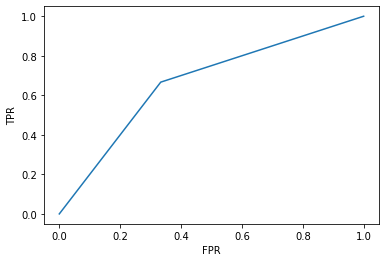

In [10]:
# ROC curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

rc = roc_curve(y,model.predict_proba(X)[:,1])
fpr = rc[0] 
tpr = rc[1]
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

Our data is simple enough that the default threshold of 0.5 is already the best. 
The thresholds used to plot the curve is stored in the third array returned by ```roc_curve```:

In [11]:
# Positive threshold
rc[2]

array([1.65806291, 0.65806291, 0.34617635])

### Area Under the Curve (AUC)

Because ROC is a curve, it is made up of a series of numbers. 
To summarize the curve in a single number, we can compute the area under the curve,
or **AUC** for short. 


In [12]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc_score(y,model.predict_proba(X)[:,1])

0.6666666666666667

The higher AUC is the better: 
- In the best-case scenario, we get a 100% true positive rate regardless of the threshold, resulting in a AUC of **1**.
- In the worst-case scenario, true positive rate equals false positive rate, resulting in a AUC of **0.5**.

Wait, why is not the worse classification one that has false positive rate increasing much faster than true positive rate? Do you know why?

## C. Common Classification Methods

Before we proceed, let us make the task more difficult.
The above example is in effect already categorized. What if we have latitudinal and longitudinal data instead?

| Customer |   Address   | Latitude | Longitude | High Spending |
|:--------:|:-----------:|:--------:|:---------:|:-------------:|
|     1    |   Central   |  22.2819 |  114.1581 |       1       |
|     2    |  Admiralty  |  22.2796 |  114.1655 |       1       |
|     3    | North Point |  22.2871 |  114.1917 |       0       |
|     4    |    Shatin   |  22.3771 |  114.1974 |       1       |
|     5    |    Fo Tan   |  22.3969 |  114.1959 |       0       |
|     6    |  Ma On Shan |  22.4221 |  114.2324 |       0       |
|     7    |   Chai Wan  |   22.27  |   114.24  |       ?       |

In [13]:
# Training data
y = data["hi_spending"]
X = data[["latitude","longitude"]]

# Test data
X_ChaiWan = [[22.27,114.24]]
X_Shatin = [X.iloc[3].values]
X_NorthPoint = [X.iloc[2].values]
X_Fotan = [X.iloc[4].values]

# Logistic regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X,y)
y_predict = model.predict(X)

tw = 50 #title column width
print("Model Accuracy:".ljust(tw),f1_score(y,y_predict))
print("Chai Wan Prediction (high spending = 1):".ljust(tw),model.predict(X_ChaiWan)[0])
print("Chai Wan Est. Prob - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_ChaiWan)[0])
print("North Point Prediction (high spending = 1):".ljust(tw),model.predict(X_NorthPoint)[0])
print("North Point Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_NorthPoint)[0])    
print("Shatin Prediction (high spending = 1):".ljust(tw),model.predict(X_Shatin)[0])
print("Shatin Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_Shatin)[0])
print("Fo Tan Prediction (high spending = 1):".ljust(tw),model.predict(X_Fotan)[0])
print("Fo Tan Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_Fotan)[0])

Model Accuracy:                                    0.6666666666666666
Chai Wan Prediction (high spending = 1):           1
Chai Wan Est. Prob - Pr(Low) Pr(High):             [0.49866256 0.50133744]
North Point Prediction (high spending = 1):        1
North Point Est. Prob. - Pr(Low) Pr(High):         [0.49913386 0.50086614]
Shatin Prediction (high spending = 1):             0
Shatin Est. Prob. - Pr(Low) Pr(High):              [0.50071205 0.49928795]
Fo Tan Prediction (high spending = 1):             0
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [0.50106881 0.49893119]


Since we are going run the same tests for all the models in this notebook, it would be helpful to write a function for that so we will not need to type the same code repeatedly:

In [14]:
# Helper function to evaluate model accuracy and generate some predictions
def summarize(model,data):
    # Data
    y = data["hi_spending"]
    X = data[["latitude","longitude"]]    
    
    # Test data
    X_ChaiWan = [[22.27,114.24]]
    X_Shatin = [[22.3771,114.1974]]
    X_NorthPoint = [[22.2871,114.1917]]
    X_Fotan = [[22.3969,114.1959]]    
    
    # Prediction
    y_predict = model.predict(X)
    
    tw = 50 # title column width
    print("Model Accuracy:".ljust(tw),f1_score(y,y_predict))
    print("Chai Wan Prediction (high spending = 1):".ljust(tw),model.predict(X_ChaiWan)[0])
    print("Chai Wan Est. Prob - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_ChaiWan)[0])
    print("North Point Prediction (high spending = 1):".ljust(tw),model.predict(X_NorthPoint)[0])
    print("North Point Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_NorthPoint)[0])    
    print("Shatin Prediction (high spending = 1):".ljust(tw),model.predict(X_Shatin)[0])
    print("Shatin Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_Shatin)[0])
    print("Fo Tan Prediction (high spending = 1):".ljust(tw),model.predict(X_Fotan)[0])
    print("Fo Tan Est. Prob. - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_Fotan)[0])

We will also write a function to highlight the decision boundaries with different colors. This function uses the ```basemap``` library, which you can install with ```conda install -c conda-forge basemap```. The function is a bit complicated, so it is okay if you do not understand how it works right now.

In [15]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)
import matplotlib.pyplot as plt
import os
if "PROJ_LIB" not in os.environ:
    os.environ["PROJ_LIB"] = "../Others/"
from mpl_toolkits.basemap import Basemap
import numpy as np

def drawBoundaryOnMap(model,data):
    
    # Fetch latitudinal and longtitudinal data
    lat = data['latitude'].values
    lon = data['longitude'].values

    # Map size
    padding = 0.15 # padding
    lat_min = min(lat) - padding
    lat_max = max(lat) + padding
    lon_min = min(lon) - padding
    lon_max = max(lon) + padding

    # 6x6 matplotlib figure
    plt.figure(figsize=(6,6))

    # Create map using Basemap
    m = Basemap(llcrnrlon=lon_min,
                llcrnrlat=lat_min,
                urcrnrlon=lon_max,
                urcrnrlat=lat_max,
                lat_0=(lat_max - lat_min)/2,
                lon_0=(lon_max-lon_min)/2,
                resolution = 'h',
                )
    m.drawcoastlines()
    m.drawmapboundary(fill_color='#46bcec')
    m.fillcontinents(color = 'white',lake_color='#46bcec')

    # Heatmap highlighting decision boundaries
    xy = np.mgrid[lat_min:lat_max:0.001,lon_min:lon_max:0.001]
    x_count = xy.shape[1]
    y_count = xy.shape[2]
    xy = xy.reshape(2,-1).T
    a = model.predict(xy)
    a = np.asarray(a).reshape((x_count,y_count))
    m.imshow(a, cmap='PiYG', interpolation='nearest', 
               extent=(lon_min,lon_max,lat_min,lat_max),
               alpha=0.8,zorder=5)
    m.scatter(lon, lat, marker = 'o', color='r', zorder=6)
    plt.show()

Let's try out the graphing function on the logit model:

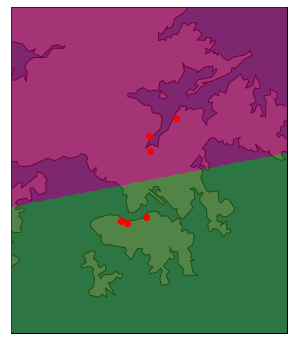

In [16]:
drawBoundaryOnMap(model,data)

Our logit model will label anything within the purple area as low income and that within the green area as high income. 

### Bayes Rule
The Bayes Rule says that

$$
P(y \mid \vec{x}) = \frac{P(\vec{x} \mid y)P(y)}{P(\vec{x})}
$$
Applying to our current problem,

$$
P(spending \mid location) = \frac{P(location \mid spending)P(spending)}{P(location)}
$$
Our task is to pick a value for $spending$ that maximizes this probability:

$$
\hat{spending} = \underset{spending}{\operatorname{argmax}}  \left \{ \frac{P(location \mid spending)P(spending)}{P(location)} \right \}
$$

Notice that $P(location)$ is constant for any given location, so we can eliminate it and get

$$
\hat{spending} = \underset{spending}{\operatorname{argmax}}  \left \{ P(location \mid spending)P(spending) \right \}
$$

To solve this maximization problem we need $P(location \mid spending)$, and there are two common ways to get that.

#### i. Native Bayes
Native Bayes assumes that all the elements of $\vec{x}$ are independent, so

$$
P( \vec{x} \mid y) = P(x_1 \mid y) \cdot P(x_2 \mid y) \cdot P( x_3 \mid y) ... 
$$

Each $P(x_i \mid y)$ is assumed to be normally distributed. The mean and standard deviations are estimated by the process.

Model Accuracy:                                    0.6666666666666666
Chai Wan Prediction (high spending = 1):           0
Chai Wan Est. Prob - Pr(Low) Pr(High):             [0.99011186 0.00988814]
North Point Prediction (high spending = 1):        1
North Point Est. Prob. - Pr(Low) Pr(High):         [0.28730036 0.71269964]
Shatin Prediction (high spending = 1):             0
Shatin Est. Prob. - Pr(Low) Pr(High):              [0.81835743 0.18164257]
Fo Tan Prediction (high spending = 1):             0
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [0.87516804 0.12483196]


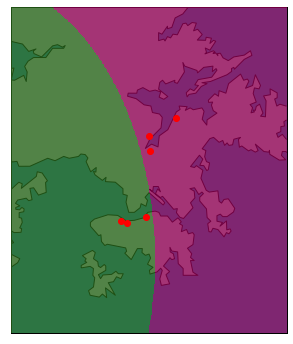

In [17]:
#Gaussian Native Bayes
from sklearn.naive_bayes import *
gnb = GaussianNB()
gnb.fit(X,y)

summarize(gnb,data)
drawBoundaryOnMap(gnb,data)

#### ii. Linear Discriminant Analysis (LDA)
LDA assumes that the features are correlated.

Model Accuracy:                                    0.6666666666666666
Chai Wan Prediction (high spending = 1):           0
Chai Wan Est. Prob - Pr(Low) Pr(High):             [9.99130115e-01 8.69885426e-04]
North Point Prediction (high spending = 1):        0
North Point Est. Prob. - Pr(Low) Pr(High):         [0.76209841 0.23790159]
Shatin Prediction (high spending = 1):             0
Shatin Est. Prob. - Pr(Low) Pr(High):              [0.54134531 0.45865469]
Fo Tan Prediction (high spending = 1):             1
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [0.40821404 0.59178596]


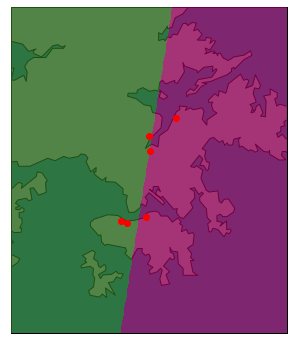

In [18]:
#Linear Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X,y)

summarize(lda,data)
drawBoundaryOnMap(lda,data)

### Support Vector Machine (SVD)

SVD looks for a boundary that separate two classes while allowing for a buffer zone where mistakes are tolerated.
<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_svm_margin_001.png">
Source: <a href="http://scikit-learn.org/stable/auto_examples/svm/plot_svm_margin.html">scikit learn</a>

Model Accuracy:                                    0.6666666666666666
Chai Wan Prediction (high spending = 1):           1
Chai Wan Est. Prob - Pr(Low) Pr(High):             [0.5 0.5]
North Point Prediction (high spending = 1):        1
North Point Est. Prob. - Pr(Low) Pr(High):         [0.5 0.5]
Shatin Prediction (high spending = 1):             0
Shatin Est. Prob. - Pr(Low) Pr(High):              [0.5 0.5]
Fo Tan Prediction (high spending = 1):             0
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [0.5 0.5]


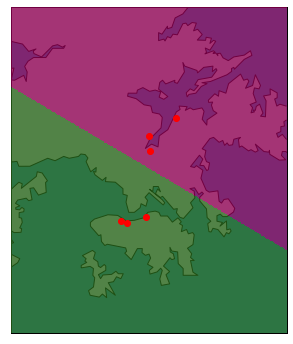

In [19]:
#Support Vector Machine Classifier
from sklearn.svm import SVC
svc = SVC(probability=True)
svc.fit(X,y)

summarize(svc,data)
drawBoundaryOnMap(svc,data)

### Decision Tree
Decision Tree repeatedly look for cutoffs that give the best prediction at each stage.

Model Accuracy:                                    1.0
Chai Wan Prediction (high spending = 1):           1
Chai Wan Est. Prob - Pr(Low) Pr(High):             [0. 1.]
North Point Prediction (high spending = 1):        0
North Point Est. Prob. - Pr(Low) Pr(High):         [1. 0.]
Shatin Prediction (high spending = 1):             1
Shatin Est. Prob. - Pr(Low) Pr(High):              [0. 1.]
Fo Tan Prediction (high spending = 1):             0
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [1. 0.]


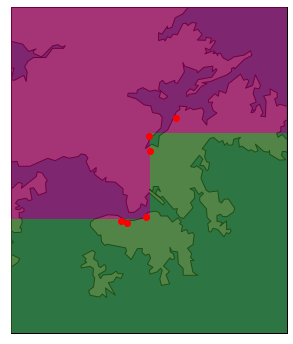

In [21]:
#Decision Tree
from sklearn import tree
#Model here

summarize(dt,data)
drawBoundaryOnMap(dt,data)

#Export tree structure to PNG format
import io
import pydot
dotfile = io.StringIO()
tree.export_graphviz(dt, out_file=dotfile)
pydot.graph_from_dot_data(dotfile.getvalue())[0].write_png("tree.png")

The script above export the tree structure in an image filed named ```tree.png```. You might get a different try structure each time you run the script. Here is one example:

<img src="http://www.ticoneva.com/econ/econ4130/images/8-tree.png" width="300">

### Nearest Neighbor
Another method we could use is to look at samples that have similar characters as the one we are trying to predict. This method is called *nearest neighbor*.

In the simpliest case, we will use the closest sample as a predictor:

Model Accuracy:                                    1.0
Chai Wan Prediction (high spending = 1):           0
Chai Wan Est. Prob - Pr(Low) Pr(High):             [1. 0.]
North Point Prediction (high spending = 1):        0
North Point Est. Prob. - Pr(Low) Pr(High):         [1. 0.]
Shatin Prediction (high spending = 1):             1
Shatin Est. Prob. - Pr(Low) Pr(High):              [0. 1.]
Fo Tan Prediction (high spending = 1):             0
Fo Tan Est. Prob. - Pr(Low) Pr(High):              [1. 0.]


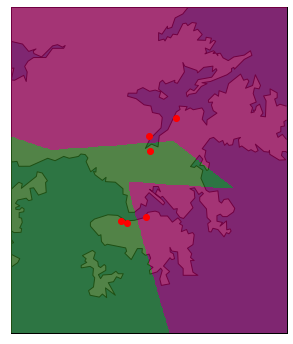

In [22]:
#Nearest Neigbhor
from sklearn.neighbors import KNeighborsClassifier

#Only consider the nearest neighbor
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X,y)

summarize(knn,data)
drawBoundaryOnMap(knn,data)

Unlike previous methods, when we try to predict the outcome of a pre-existing sample such as Shatin, we will get the correct answer. Naturally, this is because a pre-existing sample's closest neighbor is itself.

Note that the number of neighbors is crucial. For example, suppose we use the three closest neighbors instead:

In [23]:
#Consider the three closest neighbor
model = KNeighborsClassifier(n_neighbors=3)
model.fit(X,y)
print("Model Accuracy:".ljust(tw),model.score(X,y))
print("Chai Wan Prediction (high spending = 1):".ljust(tw),model.predict(X_ChaiWan))

print("Chai Wan Est. Prob - Pr(Low) Pr(High):".ljust(tw),model.predict_proba(X_ChaiWan))

Model Accuracy:                                    0.6666666666666666
Chai Wan Prediction (high spending = 1):           [1]
Chai Wan Est. Prob - Pr(Low) Pr(High):             [[0.33333333 0.66666667]]


The model estimates that Chai Wan has 1/3 chance of being low income and 2/3 chance of being high income because out of the three Hong Kong Island districts in our training data, one has low income (North Point) and two have high income (Central and Admiralty).

The following diagram sums up the estimates. The green circle indicates Chai Wan's closest neighbor, while the purple circle indicates the closest three neighbors.

<img src="../Images/8-map-knn.png" width="300">

## B. Clustering

Clustering algorithms group data without supervision. To do so, they minimize some measure of distance between data within the same group. For example, this could be simple distance as measured by the difference between values, or it could be variation as measured by variance.

| Customer |   Address   | Latitude | Longitude |
|:--------:|:-----------:|:--------:|:---------:|
|     1    |   Central   |  22.2819 |  114.1581 |
|     2    |  Admiralty  |  22.2796 |  114.1655 |
|     3    | North Point |  22.2871 |  114.1917 |
|     4    |    Shatin   |  22.3771 |  114.1974 |
|     5    |    Fo Tan   |  22.3969 |  114.1959 |
|     6    |  Ma On Shan |  22.4221 |  114.2324 |
|     7    |   Chai Wan  |   22.27  |   114.24  |

In [24]:
# data
raw_data2 = [
            [1,'Central',22.2819,114.1581],
            [2,'Admiralty',22.2796,114.1655],
            [3,'North Point',22.2871,114.1917],
            [4,'Shatin',22.3771,114.1974],
            [5,'Fo Tan',22.3969,114.1959],
            [6,'Ma On Shan',22.4221,114.2324],
            [7,'Chai Wan',22.27,114.24]
            ]
labels = ['customer','address','latitude','longitude']
data2 = pd.DataFrame.from_records(raw_data2,columns=labels)

In [27]:
X3 = data2[["latitude","longitude"]]

#K-Means
from sklearn.cluster import *

#Two clusters
km = KMeans(n_clusters=2)
print(km.fit_predict(X3))

#Three clusters
km = KMeans(n_clusters=3)
print(km.fit_predict(X3))

#Four clusters
km = KMeans(n_clusters=4)
print(km.fit_predict(X3))

[1 1 1 0 0 0 1]
[2 2 2 1 1 1 0]
[0 0 0 1 1 3 2]


Notice that the labelling is random and could change between runs.

A different clustering algorithm could give different results:

In [28]:
#Agglomerative Clustering
ac = AgglomerativeClustering(n_clusters=2)
y_ac = ac.fit_predict(X3)
print(y_ac)

ac = AgglomerativeClustering(n_clusters=3)
y_ac = ac.fit_predict(X3)
print(y_ac)

ac = AgglomerativeClustering(n_clusters=4)
y_ac = ac.fit_predict(X3)
print(y_ac)

[0 0 0 1 1 1 0]
[1 1 1 0 0 0 2]
[0 0 0 1 1 3 2]


There is a very nice diagram on scikit-learn's website showing the prediction of different clustering algorithms:
<img src="http://scikit-learn.org/stable/_images/sphx_glr_plot_cluster_comparison_0011.png">